In [29]:
import csv
import numpy as np
import utils
import hrr_utils
import time


from scipy import spatial
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

N=1000

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))

    for m, pair in enumerate(verbs):
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2


def train(Past, Present):
    return np.dot(np.linalg.pinv(Present), Past)

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def graph(x, y1, y2, y3, title=None, xlabel='number of words', ylabel='average dot product'):

    fig = plt.figure(figsize=(7,7))
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    plt.plot(x, y3, label="random")
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc='upper right')
    plt.show()
    #fig.savefig('test.jpg')

In [30]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)


regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

train_frac = 2./3.

train_reg = regular[0:int(train_frac*len(regular))]
train_irreg = irregular[0:int(train_frac*len(irregular))]


test_reg = regular[int(train_frac*len(regular)):]
test_irreg = irregular[int(train_frac*len(irregular)):]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

regular.extend(irregular)
verbs = regular

In [3]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_reg + train_irreg)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_reg + test_irreg)

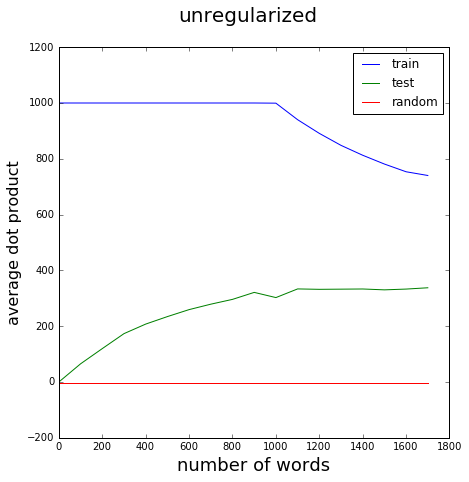

figures/unregularized_trigam_regression-N=1000-W=1758-170315


In [31]:
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 100)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y3 = np.zeros(x.shape[0])
for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = train(trainpast2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    y3[i] = sim(random_vecs, testpast2).mean()
    
graph(x,y1,y2,y3,"unregularized")

fname =  ('figures/unregularized_trigam_regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

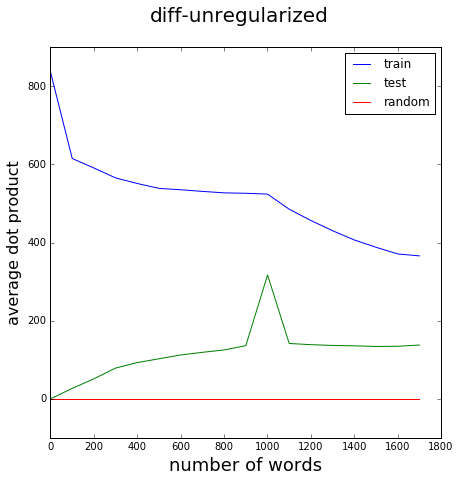

figures/diff_unregularized_trigam_regression-N=1000-W=1758-170315


In [32]:
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 100)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y3 = np.zeros(x.shape[0])
for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = train(trainpast2[:k]-trainpres2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    y3[i] = sim(random_vecs, testpast2).mean()
    
graph(x,y1,y2,y3,"diff-unregularized")

fname =  ('figures/diff_unregularized_trigam_regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [ ]:
# HD Algo Time!
def train(W, past, present):
    # col x row
    W += np.dot(present.T, past)
    return W

def train_diff(W, past2, present1, present2):
    W += np.dot(present1.T, past2-present2)
    return W

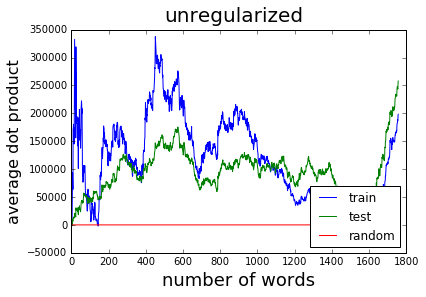

figures/unregularized_trigam_dict-N=1000-W=1758-170315


In [15]:
W = np.zeros((N,N))
W = train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y3 = np.zeros(x.shape[0])
for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    train_pred = trainpres1[:k].dot(W)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = testpres1.dot(W)
    #test_pred = np.where(test_pred>0, 1, -1)
    #print (trainpast2[:k].shape, train_pred.shape)
    #print (testpast2.shape, test_pred.shape)
    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    y3[i] = sim(random_vecs, testpast2).mean()
    
    W = train(W, trainpast2[k], trainpres1[k])

graph(x,y1,y2,y3,"diff-unregularized")

fname =  ('figures/diff_unregularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


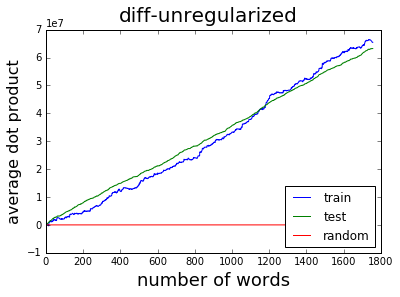

figures/diff_unregularized_trigam_dict-N=1000-W=1758-170315


In [19]:
W = np.zeros((N,N))
W = train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y3 = np.zeros(x.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    train_pred = trainpres1[:k].dot(W)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = testpres1.dot(W)
    #test_pred = np.where(test_pred>0, 1, -1)
    y1[i] = sim(train_pred, trainpast2[:k]-trainpres2[:k]).mean()
    y2[i] = sim(test_pred, testpast2-testpres2).mean()
    y3[i] = sim(random_vecs, testpast2-testpres2).mean()
    
    W = train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1,y2,y3,"diff-unregularized")

fname =  ('figures/diff_unregularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)